In [1]:
import pandas as pd

In [2]:
# 检查数据
def check_data(data):
    print("数据的前几行：")
    display(data.head())
    print("\n数据的信息：")
    data.info()
    print("\n数据是否有缺失值：")
    print(data.isnull().sum())
    print("\n数据的描述统计信息：")
    display(data.describe())

file_path = 'AAPL_timeseries.csv'
data = pd.read_csv(file_path)
check_data(data)


数据的前几行：


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099874,469033600.0
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094663,175884800.0
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087715,105728000.0
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089886,86441600.0
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092492,73449600.0



数据的信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10591 entries, 0 to 10590
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10591 non-null  object 
 1   Open       10591 non-null  float64
 2   High       10591 non-null  float64
 3   Low        10591 non-null  float64
 4   Close      10591 non-null  float64
 5   Adj Close  10591 non-null  float64
 6   Volume     10591 non-null  float64
dtypes: float64(6), object(1)
memory usage: 579.3+ KB

数据是否有缺失值：
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

数据的描述统计信息：


,Open,High,Low,Close,Adj Close,Volume
count,10591.000000,10591.000000,10591.000000,10591.000000,10591.000000,1.059100e+04
mean,16.336541,16.522291,16.153177,16.344543,15.673414,3.279409e+08
std,34.927120,35.350481,34.516790,34.950120,34.618906,3.379428e+08
min,0.049665,0.049665,0.049107,0.049107,0.038213,0.000000e+00
25%,0.286719,0.293828,0.280134,0.286830,0.237255,1.215428e+08
50%,0.484375,0.493304,0.477679,0.484375,0.402199,2.151072e+08
75%,16.014107,16.186429,15.804464,15.983393,13.836675,4.069940e+08
max,182.630005,182.940002,179.119995,182.009995,180.959747,7.421641e+09


In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt

In [7]:
# 目前用的是tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [8]:
# 数据预处理
def preprocess_data(train_set, valid_set):
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # 将训练集和验证集的Close列进行归一化
    train_data = scaler.fit_transform(train_set['Close'].values.reshape(-1, 1))
    valid_data = scaler.transform(valid_set['Close'].values.reshape(-1, 1))
    
    #调参：timesteps = 60
    time_steps = 60
    x_train, y_train = [], []
    for i in range(time_steps, len(train_data)):
        x_train.append(train_data[i-time_steps:i, 0])
        y_train.append(train_data[i, 0])
    
    x_valid, y_valid = [], []
    for i in range(time_steps, len(valid_data)):
        x_valid.append(valid_data[i-time_steps:i, 0])
        y_valid.append(valid_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    x_valid, y_valid = np.array(x_valid), np.array(y_valid)
    x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
    
    return x_train, y_train, x_valid, y_valid, scaler



In [9]:
# 调参：LSTM模型
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(60, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [10]:
# 调参：训练模型
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)

In [11]:
# 预测函数
def make_prediction(model, x_valid, scaler):
    predictions = model.predict(x_valid)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [14]:
train_set = data[(data['Date'] >= '2019-01-01') & (data['Date'] < '2022-01-01')].copy()
vaild_set = data[(data['Date'] >= '2022-01-02') & (data['Date'] < '2022-12-01')].copy()

In [16]:
# 调用预处理
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, vaild_set)
# 训练模型
model = build_model()
train_model(model, x_train, y_train)
#预测
valid_preds = make_prediction(model, x_valid, scaler)

D:\Users\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.1136
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0113
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0052
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0040
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0031
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0031
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0035
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0033
Epoch 9/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0030
Epoch 10/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0028
Epoch 11/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0026
Epoch 12/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0026
Epoch 13/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0026
Epoch 14/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0027
Epoch 15/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0025
Epoc

LSTM RMSE on validation set: 6.236255871230721


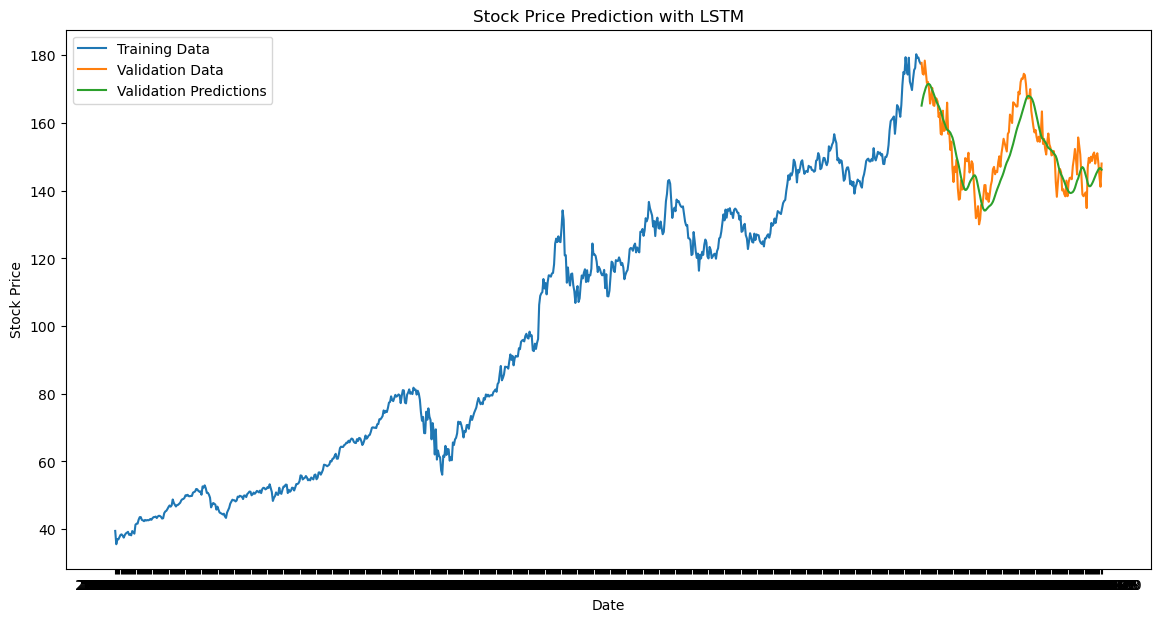

In [18]:
# 计算验证集上的RMSE
valid_rmse = np.sqrt(mean_squared_error(vaild_set['Close'].values[60:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# 可视化LSTM结果
plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close'], label='Training Data')
plt.plot(vaild_set['Date'][60:], vaild_set['Close'].values[60:], label='Validation Data')
plt.plot(vaild_set['Date'][60:], valid_preds, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()